# KOH1: Podstawowa sieć Kohonena
Adrianna Grudzień

-> na 10 maja

## Przebieg eksperymentu i wnioski
- dla neuronów o bardzo zbliżonych wartościach wag istnieje ryzyko, że neurony te będą się pokrywać w toku uczenia - czyli np. mając na wejściu 6 neuronów, na koniec uczenia zostanie ich np. 5, bo dwa z nich będą się pokrywać
- iloczyn skalarny jako metryka odległości jest metryką słabą, zdecydowanie lepsza jest odległość euklidesowa

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

In [42]:
class Koh:
    def __init__(self, k, N, M, theta_fun='gauss'):
        self.k = k
        self.N = N
        self.M = M
        self.theta_fun = theta_fun
        self._initialize_weights()
        
    def _initialize_weights(self):
        self.weights = np.random.uniform(-1,1,size=[self.k, self.N*self.M])
        
    
    @staticmethod
    def d(w_array,x_array):
        """Odległość euklidesowa (metryka)"""
        return np.linalg.norm(w_array-x_array)
    @staticmethod
    def distance(n1, n2):
        """Odległość między neuronami"""
        return np.abs(n1[0]-n2[0]) + np.abs(n1[1]-n2[1])
    @staticmethod
    def gauss_fun(x, t):
        """Funkcja Gaussa"""
        return np.exp(-np.square(x))
    @staticmethod
    def mexico_fun(x, t):
        """Meksykański kapelusz (-druga pochodna gauss_fun)"""
        return (2-4*np.square(x))*np.exp(-np.square(x))
    def theta(self,n1,n2, t):
        """Waga sąsiedztwa wygaszana w czasie"""
        if self.theta_fun == 'gauss':
            return Koh.gauss_fun(Koh.distance(n1,n2), t)
        elif self.theta_fun == 'mexico':
            return Koh.mexico_fun(Koh.distance(n1,n2), t)
    
    def alpha(self, t):
        """Wygaszanie w czasie"""
        return np.exp(-t/self.n_epochs)
    
    def draw_neurons(self, df):
        """df - ramka obserwacji"""
        weights_x = self.weights[0,:] # położenia na OX neuronów
        weights_y = self.weights[1,:]
        
        predicted_categories = []
        for x in df[:,[0,1]]:
            predicted_categories.append(self.predict_category(x))

        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.title('Predicted categories')
        plt.scatter(df[:,0], df[:,1], c=predicted_categories)
        plt.scatter(weights_x, weights_y, c='black',s=100)
        plt.subplot(1,2,2)
        plt.title('True categories')
        plt.scatter(df[:,0], df[:,1], c=df[:,2])
        plt.scatter(weights_x, weights_y, c='black',s=100)
        plt.show()
    
    def find_the_nearest_neuron(self, x):
        """Znajdź neuron najbliższy obserwacji x"""
        distances = []
        for i in range(self.weights.shape[1]):
            distances.append(Koh.d(self.weights[:,i], x))
        return self.weights[:, np.argmin(distances)]
            
    def train(self, df=None, n_epochs=10):
        """data - ramka danych wraz z kategorią (x,y,c)"""
        self.n_epochs = n_epochs

        print('Random weights')
        self.draw_neurons(df)
        for t in range(n_epochs):
            np.random.shuffle(df)
            data = np.array(df[:,[0,1]])
            for x in data:
                i_min, j_min = self.find_the_nearest_neuron(x)
            
                for neuron_num in range(self.weights.shape[1]):       
                    self.weights[:,neuron_num] += self.theta([i_min,j_min], self.weights[:,neuron_num], t)*self.alpha(t)*(x - self.weights[:,neuron_num])
            
            if t%1==0:
                print('Number of epoch: ', t+1)
                self.draw_neurons(df)
                    
    def predict_category(self, x):
        """Przewidź kategorię jednej obserwacji"""
        distances = []
        for i in range(self.weights.shape[1]):
            distances.append(Koh.d(self.weights[:,i], x))
        return int(np.argmin(distances))

## Zbiór `hexagon`

          x         y  c
0  2.402047  3.728695  1
1 -0.660032  7.047206  0
2  2.202839 -2.394303  2
3  3.179183  2.593885  1
4  3.173320 -2.152688  2


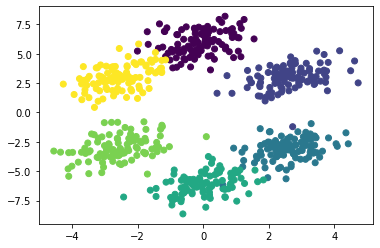

In [3]:
hexagon = pd.read_csv("mio2/hexagon.csv")
print(hexagon.head())
plt.scatter(hexagon.x, hexagon.y, c=hexagon.c)
plt.show()

Random weights


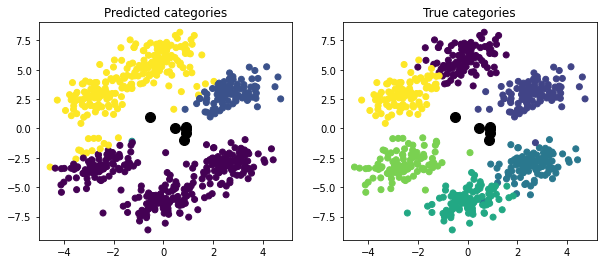

Number of epoch:  1


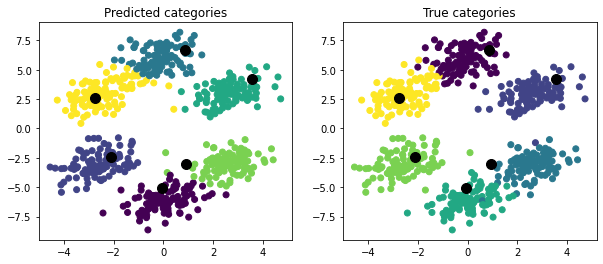

Number of epoch:  2


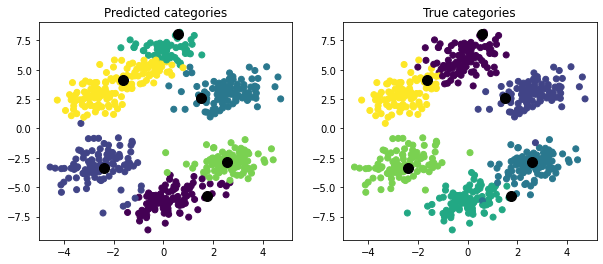

Number of epoch:  3


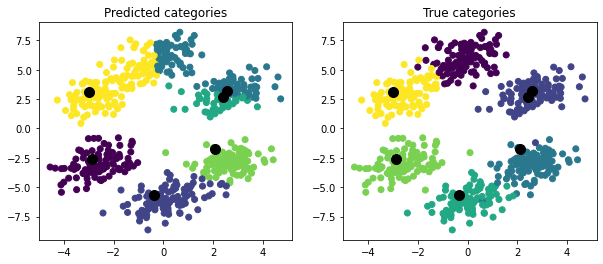

Number of epoch:  4


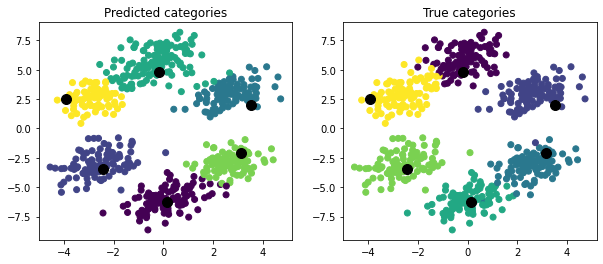

Number of epoch:  5


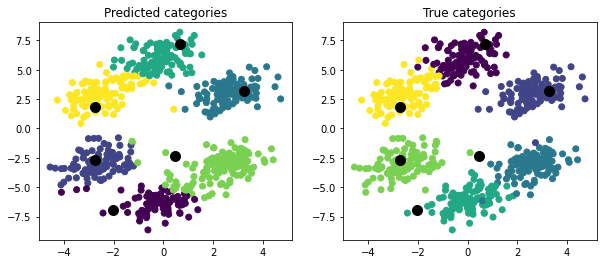

Number of epoch:  6


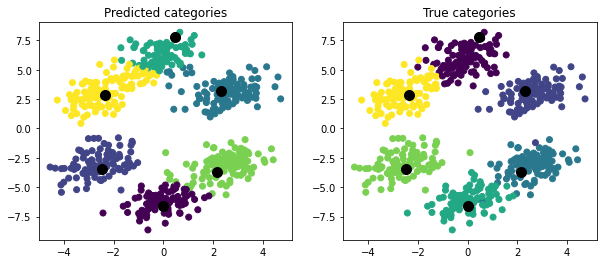

Number of epoch:  7


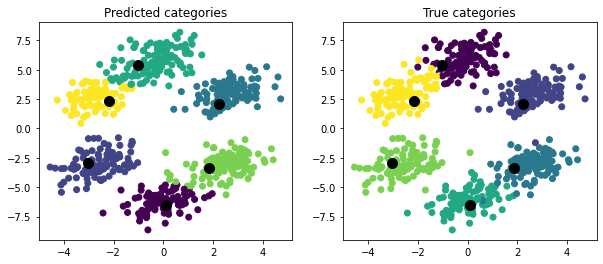

Number of epoch:  8


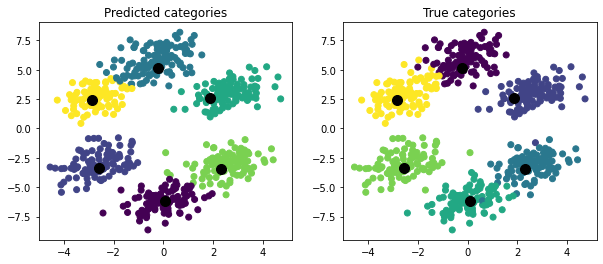

Number of epoch:  9


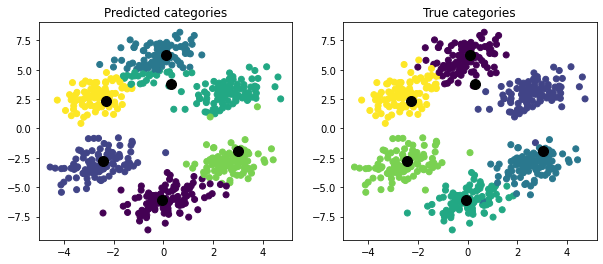

Number of epoch:  10


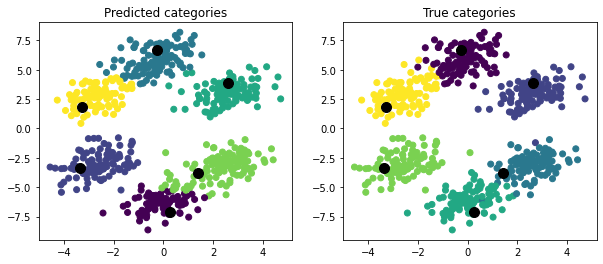

Number of epoch:  11


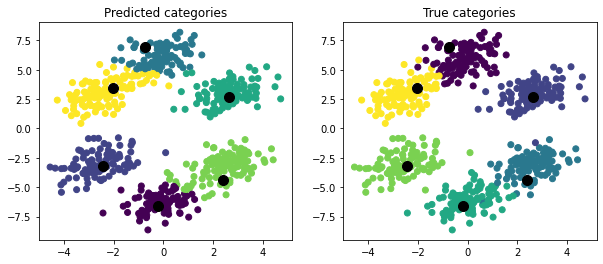

Number of epoch:  12


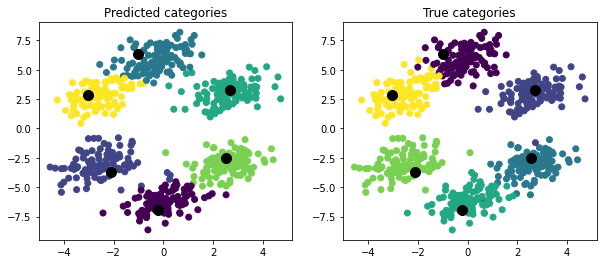

Number of epoch:  13


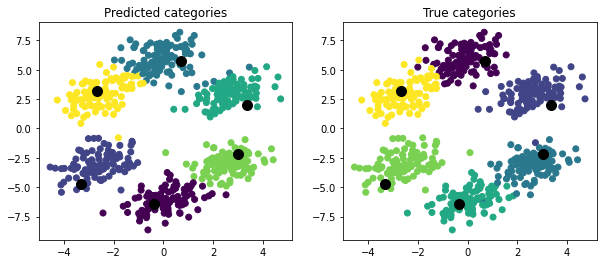

Number of epoch:  14


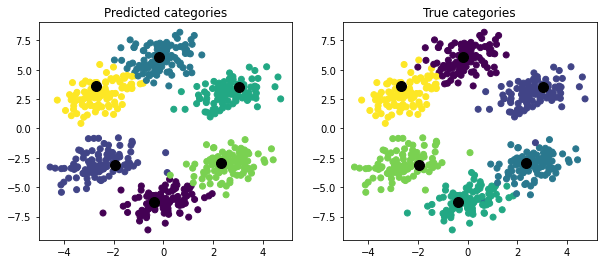

Number of epoch:  15


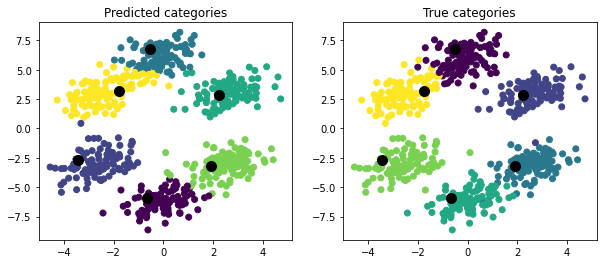

Number of epoch:  16


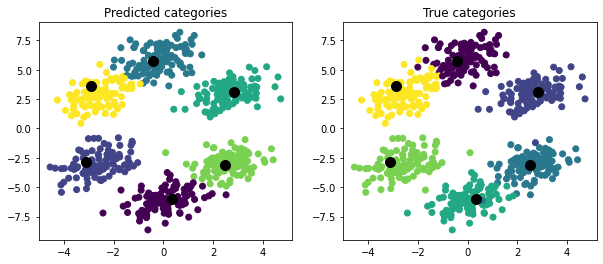

Number of epoch:  17


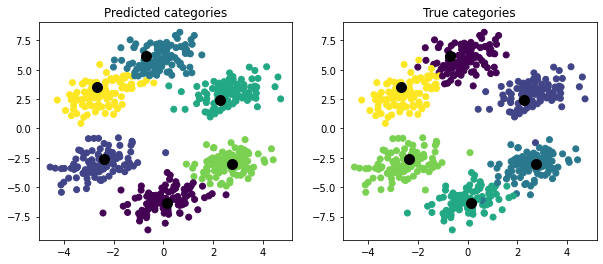

Number of epoch:  18


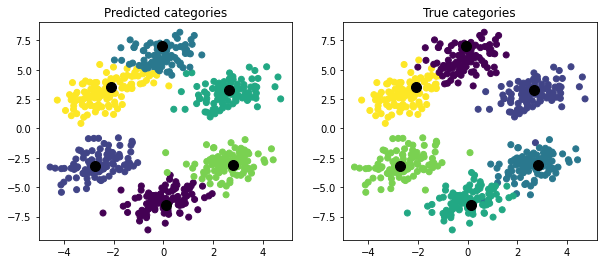

Number of epoch:  19


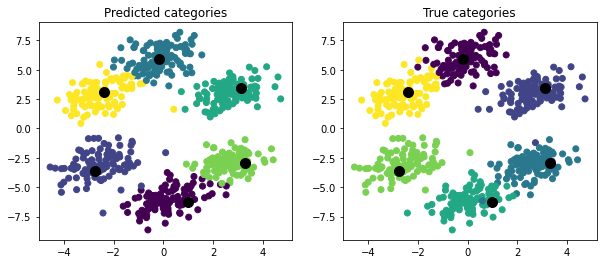

Number of epoch:  20


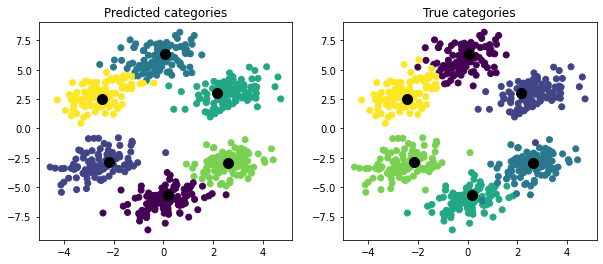

In [43]:
# k - wymiar danych (liczba kolumn)
koh = Koh(k=2, N=3, M=2, theta_fun='gauss')
koh.train(df=np.array(hexagon), n_epochs=20)

## `Cube`

In [ ]:
cube = pd.read_csv("mio2/cube.csv")
print(cube.head())

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(cube.x, cube.y, cube.z, c=cube.c)
plt.show()

In [ ]:
koh_c = Koh(k=3, N=4, M=2)
koh.train(data=np.array(cube[['x','y','z']]))

In [ ]:
# opracować analogiczną funkcję

def get_nearest_cluster(self, point):
        """ Retrieves the closest cluster of a point. """

        # Initially the result is set to the first neuron.
        nearest_cluster = self._clusters[0]
        best_distance = distance.euclidian(self._clusters[0], point)

        # We look for a closer neuron in the neuron list.
        for i in xrange(1, len(self._clusters)):
            tmp_distance = distance.euclidian(self._clusters[i], point)
            if tmp_distance < best_distance:
                nearest_cluster = self._clusters[i]
                best_distance = tmp_distance

        return nearest_cluster